In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

### ResNet with convolutional block

> Resizing logic (note this does skip connections after 2 conv layers because figure is ResNet-50, however for ResNet-34 and ResNet-18 we skip after 1 conv block  

![conv block resnet](./ResidualBlock.png)

image source: https://stackoverflow.com/questions/58200107/stuck-understanding-resnets-identity-block-and-convolutional-blocks

Helpful resources (implementations of residual blocks): https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L14/2-resnet-example.ipynb 

https://stackoverflow.com/questions/60817390/implementing-a-simple-resnet-block-with-pytorch


In [3]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

# Trying an implementation of ResNet 

class IdentityResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        if input_channel != output_channel:
            raise ValueError(f'Use ConvolutionalResidualBlock. input_channel={input_channel} != output_channel={output_channel}')
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        
    def forward(self, x):
        shortcut = x
        block = self.block(x)
        x = nn.functional.relu(block + shortcut)
        return x


class ConvolutionalResidualBlock(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            
            nn.Conv2d(output_channel, output_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channel)
        )
        
        # Adjusting channels of input layers to make addition to output layer possible.
        self.skip_connection = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(output_channel)
        )
        
        self.block_type = block_type
        
    def forward(self, x):
        if self.block_type is 'convolution':
            shortcut = self.skip_connection(x)
        else:
            shortcut = x
        block = self.block(x)
        x = nn.functional.relu(block + shortcut)
        return x


## Should we try maxpooling after residual blocks?
## ResNet18 Architecture: https://www.researchgate.net/figure/Original-ResNet-18-Architecture_fig1_336642248
## ResNet18 Architecture: https://www.researchgate.net/profile/Paolo-Napoletano/publication/322476121/figure/tbl1/AS:668726449946625@1536448218498/ResNet-18-Architecture.png
class ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.initial_cnn_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2)),
        )
        
        self.residual_block_1 = IdentityResidualBlock(64, 64)
        self.residual_block_2 = ConvolutionalResidualBlock(64, 128)
        
        self.residual_block_3 = IdentityResidualBlock(128, 128)
        self.residual_block_4 = ConvolutionalResidualBlock(128, 256)
        
        self.residual_block_5 = IdentityResidualBlock(256, 256)
        self.residual_block_6 = ConvolutionalResidualBlock(256, 512)
        
        self.residual_block_7 = IdentityResidualBlock(512, 512)
        
        # shrink final conv layer width to 1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512*1*1, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            
            nn.Dropout(p=0.2),
            nn.Linear(1024, 8)
        )
    
    def forward(self, x):
        x = self.initial_cnn_layer(x)
        
        x = self.residual_block_1(x)
        x = self.residual_block_2(x)
        x = self.residual_block_3(x)
        x = self.residual_block_4(x)        
        x = self.residual_block_5(x)
        x = self.residual_block_6(x)        
        x = self.residual_block_7(x)        
        
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        
        return F.log_softmax(x, dim=1) 
        

In [4]:
net = ResNet18()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.001
# optimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 200
epochs = 100


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
ResNet18(
  (initial_cnn_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (residual_block_1): ResidualBlock(
    (block): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

13045448

### Plotting Helper functions

## HW 2 Main

In [5]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [6]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
    time_elapsed = time.time() - start_time  ## Added Line
    print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## Added
    
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## Added Line
torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")


Using device: cuda:0

Start training...


C:\Users\abrar\anaconda3\lib\site-packages\torchvision\transforms\functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  ..\aten\src\ATen\LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


ep 1, loss: 64.56, 6400 train 21.11%, 1600 test 23.88%
Time elapsed: 0:01:33.875743
ep 2, loss: 58.85, 6400 train 29.12%, 1600 test 36.06%
Time elapsed: 0:04:30.206522
ep 3, loss: 55.15, 6400 train 33.94%, 1600 test 31.69%
Time elapsed: 0:05:29.164329
ep 4, loss: 52.36, 6400 train 37.23%, 1600 test 34.00%
Time elapsed: 0:06:29.151180
ep 5, loss: 51.27, 6400 train 39.84%, 1600 test 40.12%
Time elapsed: 0:07:29.509540
ep 6, loss: 49.58, 6400 train 40.77%, 1600 test 34.44%
Time elapsed: 0:08:30.567040
ep 7, loss: 48.26, 6400 train 43.83%, 1600 test 49.94%
Time elapsed: 0:09:30.298446
ep 8, loss: 46.38, 6400 train 46.56%, 1600 test 39.81%
Time elapsed: 0:10:29.981963
ep 9, loss: 45.70, 6400 train 47.70%, 1600 test 28.56%
Time elapsed: 0:11:29.592006
ep 10, loss: 44.57, 6400 train 48.45%, 1600 test 42.00%
[[ 93.   1.   0.   0.   0.   3.  59.  33.]
 [  0.  99.   1.   1.   4.  22.  56.  18.]
 [  6.  63.  29.   5.  16.  31.  47.   2.]
 [  5.   4.   2.  21.   2.  57. 119.  12.]
 [  0.  91.  24.

ep 71, loss: 15.53, 6400 train 83.28%, 1600 test 74.38%
Time elapsed: 0:59:59.593259
ep 72, loss: 15.26, 6400 train 83.34%, 1600 test 70.88%
Time elapsed: 1:00:57.937365
ep 73, loss: 14.79, 6400 train 84.48%, 1600 test 72.00%
Time elapsed: 1:01:57.298565
ep 74, loss: 14.98, 6400 train 83.69%, 1600 test 72.50%
Time elapsed: 1:02:55.651966
ep 75, loss: 14.36, 6400 train 84.39%, 1600 test 73.75%
Time elapsed: 1:03:53.808530
ep 76, loss: 14.93, 6400 train 84.36%, 1600 test 71.81%
Time elapsed: 1:04:51.985709
ep 77, loss: 14.88, 6400 train 83.67%, 1600 test 68.88%
Time elapsed: 1:05:51.326451
ep 78, loss: 14.20, 6400 train 84.66%, 1600 test 75.94%
Time elapsed: 1:06:51.723768
ep 79, loss: 13.23, 6400 train 85.47%, 1600 test 76.69%
Time elapsed: 1:07:51.272219
ep 80, loss: 12.89, 6400 train 86.08%, 1600 test 74.69%
[[172.   1.   0.   4.   1.   0.   5.   6.]
 [  0. 106.   3.   3.  15.  39.  14.  21.]
 [  6.   6. 134.   2.  18.  24.   8.   1.]
 [ 22.   1.   6. 156.   5.  20.   2.  10.]
 [  3. 

ep 141, loss: 6.70, 6400 train 92.91%, 1600 test 73.88%
Time elapsed: 1:48:22.295921
ep 142, loss: 6.89, 6400 train 92.78%, 1600 test 74.88%
Time elapsed: 1:49:00.368311
ep 143, loss: 6.40, 6400 train 93.23%, 1600 test 74.88%
Time elapsed: 1:49:38.448259
ep 144, loss: 7.13, 6400 train 92.73%, 1600 test 78.38%
Time elapsed: 1:50:16.589472
ep 145, loss: 6.48, 6400 train 93.36%, 1600 test 78.88%
Time elapsed: 1:50:54.689154
ep 146, loss: 5.73, 6400 train 94.17%, 1600 test 77.50%
Time elapsed: 1:51:32.761307
ep 147, loss: 6.57, 6400 train 92.78%, 1600 test 77.50%
Time elapsed: 1:52:10.891391
ep 148, loss: 6.95, 6400 train 92.77%, 1600 test 77.19%
Time elapsed: 1:52:48.966409
ep 149, loss: 6.43, 6400 train 93.05%, 1600 test 75.12%
Time elapsed: 1:53:27.032276
ep 150, loss: 6.58, 6400 train 93.11%, 1600 test 75.19%
[[175.   0.   1.   4.   1.   1.   2.   5.]
 [  1. 122.   4.   1.   7.  25.  18.  23.]
 [  6.  13. 111.   2.  30.  21.  10.   6.]
 [ 17.   2.   1. 172.   1.  14.   8.   7.]
 [  3. 

ep 211, loss: 4.11, 6400 train 95.86%, 1600 test 76.69%
Time elapsed: 2:33:00.554086
ep 212, loss: 4.04, 6400 train 96.22%, 1600 test 76.81%
Time elapsed: 2:33:41.607075
ep 213, loss: 4.16, 6400 train 95.98%, 1600 test 73.25%
Time elapsed: 2:34:21.670089
ep 214, loss: 4.26, 6400 train 95.61%, 1600 test 77.31%
Time elapsed: 2:35:01.913309
ep 215, loss: 4.27, 6400 train 95.72%, 1600 test 79.00%
Time elapsed: 2:35:42.146435
ep 216, loss: 4.00, 6400 train 95.75%, 1600 test 76.88%
Time elapsed: 2:36:22.798933
ep 217, loss: 4.01, 6400 train 95.84%, 1600 test 78.69%
Time elapsed: 2:37:02.633505
ep 218, loss: 4.26, 6400 train 95.69%, 1600 test 76.12%
Time elapsed: 2:37:44.375061
ep 219, loss: 3.94, 6400 train 95.89%, 1600 test 74.88%
Time elapsed: 2:38:24.109976
ep 220, loss: 4.78, 6400 train 95.02%, 1600 test 76.75%
[[155.   1.   1.  16.   1.   1.  10.   4.]
 [  0. 149.   2.   4.   3.  10.  26.   7.]
 [  4.  16.  97.  12.  33.  23.  12.   2.]
 [  6.   1.   0. 200.   2.   4.   6.   3.]
 [  1. 

### Analysis

batch size: 200
learning rate: 0.001
train_val_split: 0.8
epochs: 250
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 811, 1: 799, 2: 801, 3: 778, 4: 797, 5: 807, 6: 797, 7: 810}
test data distribution - {0: 189, 1: 201, 2: 199, 3: 222, 4: 203, 5: 193, 6: 203, 7: 190}


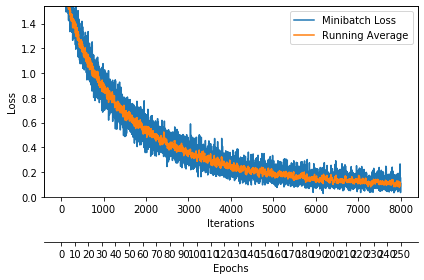

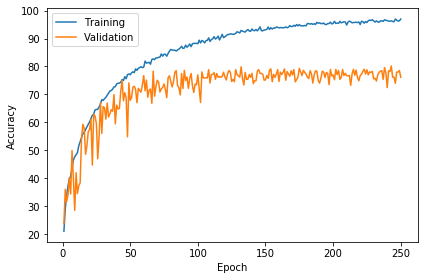

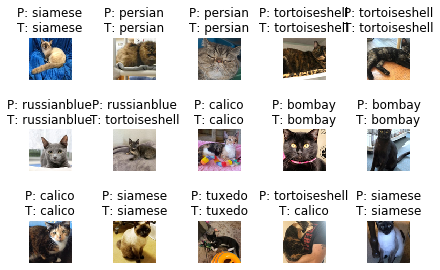

[[166   1   2   4   0   2   7   7]
 [  0 134   5   1   5  14  24  18]
 [  5  12 156   0   9   7   5   5]
 [ 15   3   7 173   3   5   9   7]
 [  2  10  14   8 158   5   2   4]
 [  1   6   7   4   2 160  10   3]
 [  8  11   3  10   2   5 156   8]
 [  3  11   1   3   3   2   3 164]]


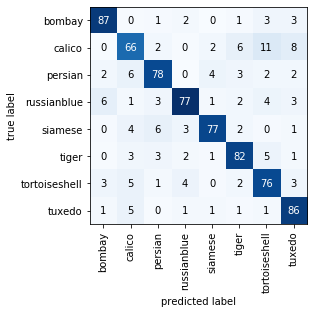

In [8]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
print(conf_matrix)
plot_confusion_matrix(conf_matrix, class_names=cat_dict.values(), test_data_distribution=test_data_distribution)
plt.show()